**BUSINESS UNDERSTANDING**   

**What Drives the Price of a Car?**   
The features mostly affecting used car prices will be identified using a subset of a dataset from Kaggle.    
The original dataset contained information on 3 million used cars.  
Once the factors that make a car more or less expensive are identified, a predictive model will be constructed to validate these factors.    
At the same time, the weights of these features in the prediction shall be determined.   
The output of this exercise will be offered for application to a used car dealer.

**Import the required libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV
import warnings
warnings.filterwarnings('ignore')

**Load the dataset**

In [2]:
vehicle = pd.read_csv('data/vehicles.csv')

**DATA UNDERSTANDING**  

**Size of dataset**  
There are 18 columns or features and 426,880 rows.

**Missing Values**  
There is quite a lot of missing values (1,215,152 total).      
After some analysis, the missing values will be replaced with the column mode as is suitable for categorical values.

**Dropped Columns**  
Some of the features which will likely not affect the price of the used cars will be dropped as follows:
1. 'id' and 'VIN' - identification only
2. 'region' and 'state' - the analysis will be national in order to simplify the analysis
3. 'fuel' - only vehicles running on gasoline (84% of data) were considered, for simplicity
4. 'title_status' - on vehicles with clean titles (96% of data) were considered, for simplicity
5. 'size' - percentage of missing values (72%) was over the threshold of 60%

**Duplicate Rows**           
102,476 duplicate rows will be removed.

In [3]:
# examine the dataset
vehicle.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [5]:
total_missing_values = vehicle.isnull().sum().sum()  # count the total number of missing values
total_missing_values

np.int64(1215152)

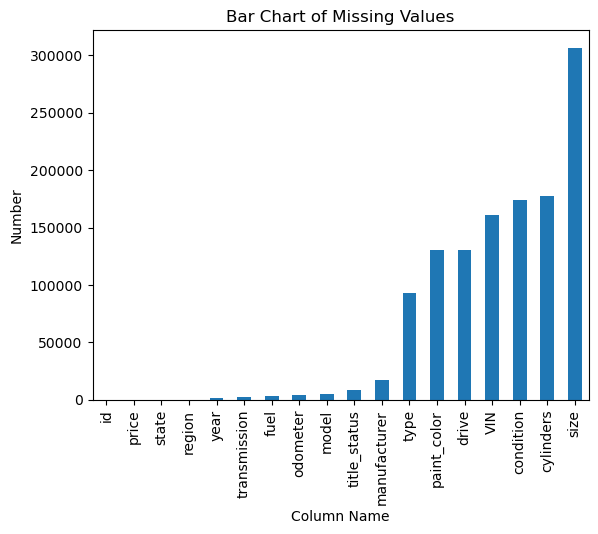

In [6]:
# plot missing values
vehicle.isnull().sum().sort_values().plot(kind='bar')
plt.title('Bar Chart of Missing Values')
plt.xlabel('Column Name')
plt.ylabel('Number')
plt.show()

In [7]:
# count of 'region' elements
val_region = vehicle['region'].value_counts()
val_region

region
columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: count, Length: 404, dtype: int64

In [8]:
# verify value counts for column 'state'
pd.set_option('display.max_rows', 200)
val_count_state = vehicle['state'].value_counts()
val_count_state

state
ca    50614
fl    28511
tx    22945
ny    19386
oh    17696
or    17104
mi    16900
nc    15277
wa    13861
pa    13753
wi    11398
co    11088
tn    11066
va    10732
il    10387
nj     9742
id     8961
az     8679
ia     8632
ma     8174
mn     7716
ga     7003
ok     6792
sc     6327
mt     6294
ks     6209
in     5704
ct     5188
al     4955
md     4778
nm     4425
mo     4293
ky     4149
ar     4038
ak     3474
la     3196
nv     3194
nh     2981
dc     2970
me     2966
hi     2964
vt     2513
ri     2320
sd     1302
ut     1150
wv     1052
ne     1036
ms     1016
de      949
wy      610
nd      410
Name: count, dtype: int64

**DATA PREPARATION**  

Columns were dropped where they have no bearing on the price of the used vehicle. Some were dropped for simplicity of the analysis.  
Duplicate rows were removed. Missing values were imputed. A column with a high percentage of missing values was dropped. Outliers were removed from the features especially from the price, odometer and year data.

In [9]:
vehicle = vehicle.drop(columns=['id','region','state','VIN'])  # drop columns 'id', 'region', 'state', and 'VIN'

In [10]:
# calculate percentage of missing values for columns in list
column_missing_list = ['price','year','transmission','fuel','odometer','model','title_status','manufacturer'\
                      ,'type','paint_color','drive','condition','cylinders','size']
for col in column_missing_list:
    num_missing_values = vehicle[col].isnull().sum()
    print(f"The percentage of missing values in the column '{col}' is {num_missing_values/vehicle.shape[0]*100: .2f}%")

The percentage of missing values in the column 'price' is  0.00%
The percentage of missing values in the column 'year' is  0.28%
The percentage of missing values in the column 'transmission' is  0.60%
The percentage of missing values in the column 'fuel' is  0.71%
The percentage of missing values in the column 'odometer' is  1.03%
The percentage of missing values in the column 'model' is  1.24%
The percentage of missing values in the column 'title_status' is  1.93%
The percentage of missing values in the column 'manufacturer' is  4.13%
The percentage of missing values in the column 'type' is  21.75%
The percentage of missing values in the column 'paint_color' is  30.50%
The percentage of missing values in the column 'drive' is  30.59%
The percentage of missing values in the column 'condition' is  40.79%
The percentage of missing values in the column 'cylinders' is  41.62%
The percentage of missing values in the column 'size' is  71.77%


In [11]:
# drop column 'size' based on 60% cut-off for missing values
vehicle = vehicle.drop(columns=['size'])
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  type          334022 non-null  object 
 12  paint_color   296677 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 42.3+ MB


In [12]:
# verify value counts for column 'fuel'
val_count_fuel = vehicle['fuel'].value_counts()
val_count_fuel

fuel
gas         356209
other        30728
diesel       30062
hybrid        5170
electric      1698
Name: count, dtype: int64

In [13]:
# calculate percentages of 'fuel'
pct_val_count_fuel = vehicle['fuel'].value_counts(normalize=True)*100
pct_val_count_fuel

fuel
gas         84.037918
other        7.249444
diesel       7.092319
hybrid       1.219722
electric     0.400597
Name: proportion, dtype: float64

In [14]:
# drop rows where fuel is other than gasoline, for simplicity, the analysis will only focus on 
# vehicles running on gasoline (84% of 'fuel' data)
fuel_list = ['diesel','hybrid','other','electric']
vehicle = vehicle[~vehicle['fuel'].isin(fuel_list)]
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 359222 entries, 0 to 426879
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         359222 non-null  int64  
 1   year          358171 non-null  float64
 2   manufacturer  346830 non-null  object 
 3   model         355426 non-null  object 
 4   condition     213141 non-null  object 
 5   cylinders     222459 non-null  object 
 6   fuel          356209 non-null  object 
 7   odometer      354999 non-null  float64
 8   title_status  351619 non-null  object 
 9   transmission  356980 non-null  object 
 10  drive         252510 non-null  object 
 11  type          278630 non-null  object 
 12  paint_color   249806 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 38.4+ MB


In [15]:
# verify value counts for column 'fuel'
val_count_fuel = vehicle['fuel'].value_counts()
val_count_fuel

fuel
gas    356209
Name: count, dtype: int64

In [16]:
# drop column 'fuel' because it's no longer needed - analysis on gas-fired vehicles only
vehicle = vehicle.drop(columns=['fuel'])
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 359222 entries, 0 to 426879
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         359222 non-null  int64  
 1   year          358171 non-null  float64
 2   manufacturer  346830 non-null  object 
 3   model         355426 non-null  object 
 4   condition     213141 non-null  object 
 5   cylinders     222459 non-null  object 
 6   odometer      354999 non-null  float64
 7   title_status  351619 non-null  object 
 8   transmission  356980 non-null  object 
 9   drive         252510 non-null  object 
 10  type          278630 non-null  object 
 11  paint_color   249806 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 35.6+ MB


In [17]:
# verify value counts for column 'title_status'
val_count_title = vehicle['title_status'].value_counts()
val_count_title

title_status
clean         339229
rebuilt         6828
salvage         3491
lien            1205
missing          715
parts only       151
Name: count, dtype: int64

In [18]:
# calculate percentages of 'title_status'
pct_val_count_title = vehicle['title_status'].value_counts(normalize=True)*100
pct_val_count_title

title_status
clean         96.476300
rebuilt        1.941875
salvage        0.992836
lien           0.342700
missing        0.203345
parts only     0.042944
Name: proportion, dtype: float64

In [19]:
# drop rows where title status is other than clean, for simplicity, the analysis will only focus on 
# vehicles with clean title (96% of 'title_status' data)
title_list = ['rebuilt','salvage','lien','missing','parts only']
vehicle = vehicle[~vehicle['title_status'].isin(title_list)]
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 346832 entries, 0 to 426879
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         346832 non-null  int64  
 1   year          345887 non-null  float64
 2   manufacturer  335028 non-null  object 
 3   model         343289 non-null  object 
 4   condition     204235 non-null  object 
 5   cylinders     212923 non-null  object 
 6   odometer      342616 non-null  float64
 7   title_status  339229 non-null  object 
 8   transmission  344596 non-null  object 
 9   drive         243653 non-null  object 
 10  type          270052 non-null  object 
 11  paint_color   240744 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 34.4+ MB


In [20]:
# verify value counts for column 'title_status'
val_count_title = vehicle['title_status'].value_counts()
val_count_title

title_status
clean    339229
Name: count, dtype: int64

In [21]:
# drop column 'title_status' because it's no longer needed - analysis on clean titles only
vehicle = vehicle.drop(columns=['title_status'])
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 346832 entries, 0 to 426879
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         346832 non-null  int64  
 1   year          345887 non-null  float64
 2   manufacturer  335028 non-null  object 
 3   model         343289 non-null  object 
 4   condition     204235 non-null  object 
 5   cylinders     212923 non-null  object 
 6   odometer      342616 non-null  float64
 7   transmission  344596 non-null  object 
 8   drive         243653 non-null  object 
 9   type          270052 non-null  object 
 10  paint_color   240744 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 31.8+ MB


In [22]:
duplicates = len(vehicle[vehicle.duplicated()])  # number of duplicate rows
print(f'There were {duplicates} duplicate rows.')

There were 137613 duplicate rows.


In [23]:
vehicle = vehicle.drop_duplicates()  # remove duplicate rows
print(f'{len(vehicle)} rows were left after the removal of duplicate rows.')

209219 rows were left after the removal of duplicate rows.


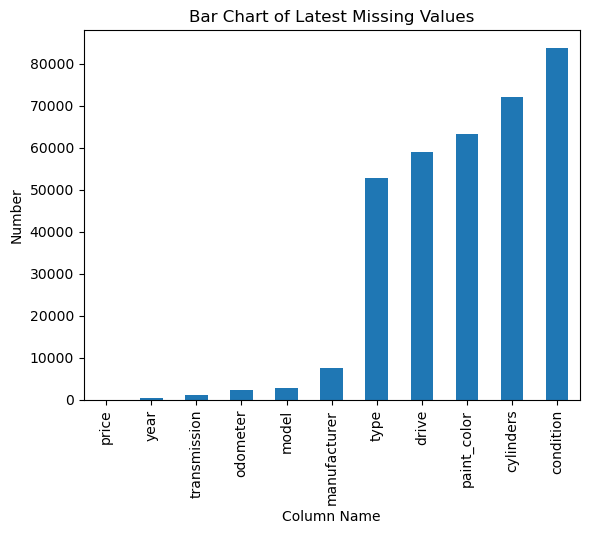

In [24]:
# plot latest missing values
vehicle.isnull().sum().sort_values().plot(kind='bar')
plt.title('Bar Chart of Latest Missing Values')
plt.xlabel('Column Name')
plt.ylabel('Number')
plt.show()

In [25]:
# remove leading and trailing white spaces
string_cols = vehicle.select_dtypes(include=['object']).columns
vehicle[string_cols] = vehicle[string_cols].apply(lambda x: x.str.strip())

In [26]:
# calculate latest percentage of missing values for columns in list
column_missing_list1 = ['price','year','transmission','odometer','model','manufacturer'\
                      ,'type','paint_color','drive','condition','cylinders']
for col in column_missing_list1:
    num_missing_values = vehicle[col].isnull().sum()
    print(f"The percentage of missing values in the column '{col}' is {num_missing_values/vehicle.shape[0]*100: .2f}%")

The percentage of missing values in the column 'price' is  0.00%
The percentage of missing values in the column 'year' is  0.25%
The percentage of missing values in the column 'transmission' is  0.58%
The percentage of missing values in the column 'odometer' is  1.15%
The percentage of missing values in the column 'model' is  1.33%
The percentage of missing values in the column 'manufacturer' is  3.58%
The percentage of missing values in the column 'type' is  25.19%
The percentage of missing values in the column 'paint_color' is  30.19%
The percentage of missing values in the column 'drive' is  28.20%
The percentage of missing values in the column 'condition' is  40.03%
The percentage of missing values in the column 'cylinders' is  34.43%


In [27]:
# list columns with missing values
list_columns_with_missing_values = vehicle.columns[vehicle.isnull().any()].tolist()
list_columns_with_missing_values

['year',
 'manufacturer',
 'model',
 'condition',
 'cylinders',
 'odometer',
 'transmission',
 'drive',
 'type',
 'paint_color']

In [28]:
# display the value count for each column
pd.set_option('display.max_rows', 200)
for i in list_columns_with_missing_values:
    count_column = vehicle[i].value_counts()  
    print(f'The value count for column {count_column} \n')

The value count for column year
2013.0    14230
2018.0    13561
2014.0    13517
2017.0    13442
2015.0    13421
2012.0    11938
2016.0    11911
2011.0    10917
2008.0    10364
2007.0     9340
2010.0     9149
2019.0     8483
2006.0     8121
2009.0     7550
2005.0     6937
2004.0     6004
2020.0     5551
2003.0     4900
2002.0     3918
2001.0     3084
2000.0     2446
1999.0     2013
1998.0     1421
1997.0     1243
2021.0     1096
1996.0      917
1995.0      896
1994.0      703
1993.0      535
1990.0      473
1991.0      458
1989.0      450
1992.0      412
1986.0      395
1987.0      393
1988.0      392
1985.0      373
1969.0      336
1968.0      330
1972.0      327
1979.0      321
1966.0      319
1978.0      295
1970.0      292
1984.0      288
1965.0      286
1973.0      283
1967.0      279
1971.0      246
1977.0      241
1974.0      223
1964.0      210
1980.0      199
1983.0      197
1976.0      196
1981.0      181
1963.0      176
1982.0      169
1955.0      160
1975.0      159
1957.0  

In [29]:
# replace missing values with column mode
for i in list_columns_with_missing_values:
    mode_column = vehicle[i].mode() 
    vehicle[i] = vehicle[i].fillna(str(mode_column))  

In [30]:
# confirm replacement of missing values
total_missing_values = vehicle.isnull().sum().sum()  
print(f'The total number of missing values is now {total_missing_values}.')

The total number of missing values is now 0.


In [31]:
# verify information
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209219 entries, 0 to 426873
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         209219 non-null  int64 
 1   year          209219 non-null  object
 2   manufacturer  209219 non-null  object
 3   model         209219 non-null  object
 4   condition     209219 non-null  object
 5   cylinders     209219 non-null  object
 6   odometer      209219 non-null  object
 7   transmission  209219 non-null  object
 8   drive         209219 non-null  object
 9   type          209219 non-null  object
 10  paint_color   209219 non-null  object
dtypes: int64(1), object(10)
memory usage: 19.2+ MB


In [32]:
# calculate percentages of 'year'
pd.reset_option("display.max_rows")
pct_val_count_year = vehicle['year'].value_counts(normalize=True)*100
pct_val_count_year

year
2013.0    6.801486
2018.0    6.481725
2014.0    6.460694
2017.0    6.424847
2015.0    6.414809
            ...   
1915.0    0.000478
1905.0    0.000478
1918.0    0.000478
1901.0    0.000478
1943.0    0.000478
Name: proportion, Length: 113, dtype: float64

In [33]:
# convert 'year' to numeric
vehicle['year'] = pd.to_numeric(vehicle['year'], errors='coerce')
# drop outliers for 'year', limit used cars to no older than 1988
vehicle = vehicle[(vehicle['year'] >= 1988) & (vehicle['year'] <= 2025)]

In [34]:
# check value counts of 'year'
pd.set_option("display.max_rows", 200)
val_count_year1 = vehicle['year'].value_counts()
val_count_year1

year
2013.0    14230
2018.0    13561
2014.0    13517
2017.0    13442
2015.0    13421
2012.0    11938
2016.0    11911
2011.0    10917
2008.0    10364
2007.0     9340
2010.0     9149
2019.0     8483
2006.0     8121
2009.0     7550
2005.0     6937
2004.0     6004
2020.0     5551
2003.0     4900
2002.0     3918
2001.0     3084
2000.0     2446
1999.0     2013
1998.0     1421
1997.0     1243
2021.0     1096
1996.0      917
1995.0      896
1994.0      703
1993.0      535
1990.0      473
1991.0      458
1989.0      450
1992.0      412
1988.0      392
2022.0       55
Name: count, dtype: int64

In [35]:
# see the unique list for 'year', used cars for analysis limited to no older than 1988, for simplicity
list_year = pd.Series(vehicle['year'].unique().tolist()).sort_values(ascending=False)
list_year

34    2022.0
22    2021.0
2     2020.0
7     2019.0
10    2018.0
3     2017.0
6     2016.0
13    2015.0
0     2014.0
4     2013.0
5     2012.0
8     2011.0
1     2010.0
18    2009.0
15    2008.0
17    2007.0
12    2006.0
16    2005.0
11    2004.0
14    2003.0
20    2002.0
28    2001.0
26    2000.0
21    1999.0
19    1998.0
23    1997.0
25    1996.0
24    1995.0
30    1994.0
32    1993.0
9     1992.0
27    1991.0
33    1990.0
31    1989.0
29    1988.0
dtype: float64

In [36]:
# calculate percentages of 'manufacturer'
pct_val_count_manufacturer = vehicle['manufacturer'].value_counts(normalize=True)*100
pct_val_count_manufacturer

manufacturer
ford                                            15.145010
chevrolet                                       12.365398
toyota                                           9.015852
honda                                            6.603018
nissan                                           5.441135
jeep                                             5.060346
bmw                                              3.454125
dodge                                            3.405088
gmc                                              3.382571
subaru                                           2.845162
hyundai                                          2.832653
mercedes-benz                                    2.766603
ram                                              2.747088
0    ford\nName: manufacturer, dtype: object     2.667527
kia                                              2.280233
volkswagen                                       2.125615
lexus                                            1.905448
c

In [37]:
# replace '0    ford\nName: manufacturer, dtype: object' with 'ford'
vehicle['manufacturer'] = vehicle['manufacturer']\
    .replace({'0    ford\nName: manufacturer, dtype: object':'ford'})

In [38]:
# recalculate percentages of 'manufacturer'
pct_val_count_manufacturer = vehicle['manufacturer'].value_counts(normalize=True)*100
pct_val_count_manufacturer

manufacturer
ford               17.812538
chevrolet          12.365398
toyota              9.015852
honda               6.603018
nissan              5.441135
jeep                5.060346
bmw                 3.454125
dodge               3.405088
gmc                 3.382571
subaru              2.845162
hyundai             2.832653
mercedes-benz       2.766603
ram                 2.747088
kia                 2.280233
volkswagen          2.125615
lexus               1.905448
chrysler            1.780353
cadillac            1.628738
audi                1.601717
mazda               1.503643
buick               1.342020
acura               1.202914
infiniti            0.997258
lincoln             0.841139
volvo               0.807113
mitsubishi          0.679016
pontiac             0.662504
mini                0.635483
rover               0.558424
saturn              0.368280
mercury             0.355770
porsche             0.351767
jaguar              0.299728
fiat                0.169629
a

In [39]:
# drop 'manufacturer' outliers with less than 2% of data
frequency_manufacturer = vehicle['manufacturer'].value_counts(normalize=True)
retain_manufacturer = frequency_manufacturer[ frequency_manufacturer > 0.02].index
vehicle = vehicle[vehicle['manufacturer'].isin(retain_manufacturer)]
val_filtered_manufacturer = vehicle['manufacturer'].value_counts()
val_filtered_manufacturer

manufacturer
ford             35598
chevrolet        24712
toyota           18018
honda            13196
nissan           10874
jeep             10113
bmw               6903
dodge             6805
gmc               6760
subaru            5686
hyundai           5661
mercedes-benz     5529
ram               5490
kia               4557
volkswagen        4248
Name: count, dtype: int64

In [40]:
# check the info
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 164150 entries, 27 to 426873
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         164150 non-null  int64  
 1   year          164150 non-null  float64
 2   manufacturer  164150 non-null  object 
 3   model         164150 non-null  object 
 4   condition     164150 non-null  object 
 5   cylinders     164150 non-null  object 
 6   odometer      164150 non-null  object 
 7   transmission  164150 non-null  object 
 8   drive         164150 non-null  object 
 9   type          164150 non-null  object 
 10  paint_color   164150 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 15.0+ MB


In [41]:
# calculate percentages of 'model'
pd.set_option('display.max_rows', 200)
pct_val_count_model = vehicle['model'].value_counts(normalize=True)*100
pct_val_count_model

model
f-150                       2.515382
silverado 1500              1.642400
1500                        1.303076
camry                       1.273226
accord                      1.233019
                              ...   
journey se blacktop         0.000609
740IL                       0.000609
gold wing                   0.000609
chevorlet silverado 1500    0.000609
96 Suburban                 0.000609
Name: proportion, Length: 17526, dtype: float64

In [42]:
# drop 'model' outliers with less than 1% of data
frequency_model = vehicle['model'].value_counts(normalize=True)
retain_model = frequency_model[ frequency_model > 0.006].index
vehicle = vehicle[vehicle['model'].isin(retain_model)]
val_filtered_model = vehicle['model'].value_counts()
val_filtered_model

model
f-150                                     4129
silverado 1500                            2696
1500                                      2139
camry                                     2090
accord                                    2024
civic                                     1821
escape                                    1682
altima                                    1672
wrangler                                  1558
tacoma                                    1498
explorer                                  1498
grand cherokee                            1474
0    f-150\nName: model, dtype: object    1464
silverado                                 1445
corolla                                   1443
cr-v                                      1334
mustang                                   1178
equinox                                   1158
fusion                                    1146
focus                                     1140
rav4                                      1134
sonata 

In [43]:
# replace '0    f-150\nName: model, dtype: object' with 'f-150'
vehicle['model'] = vehicle['model'].replace({'0    f-150\nName: model, dtype: object':'f-150',\
                                             '1500':'silverado 1500', 'silverado':'silverado 1500'})

In [44]:
# recalculate percentages of 'model'
pd.reset_option("display.max_rows")
pct_val_count_model1 = vehicle['model'].value_counts(normalize=True)*100
pct_val_count_model1

model
silverado 1500    15.382731
f-150             13.699939
camry              5.119412
accord             4.957746
civic              4.460502
escape             4.120024
altima             4.095530
wrangler           3.816289
tacoma             3.669320
explorer           3.669320
grand cherokee     3.610533
corolla            3.534599
cr-v               3.267606
mustang            2.885487
equinox            2.836497
fusion             2.807103
focus              2.792407
rav4               2.777710
sonata             2.567055
malibu             2.547459
odyssey            2.483772
outback            2.478873
impala             2.420086
Name: proportion, dtype: float64

In [45]:
# check the info
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40825 entries, 28 to 426813
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         40825 non-null  int64  
 1   year          40825 non-null  float64
 2   manufacturer  40825 non-null  object 
 3   model         40825 non-null  object 
 4   condition     40825 non-null  object 
 5   cylinders     40825 non-null  object 
 6   odometer      40825 non-null  object 
 7   transmission  40825 non-null  object 
 8   drive         40825 non-null  object 
 9   type          40825 non-null  object 
 10  paint_color   40825 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.7+ MB


In [46]:
# calculate percentages of 'condition'
pct_val_count_condition = vehicle['condition'].value_counts(normalize=True)*100
pct_val_count_condition

condition
0    excellent\nName: condition, dtype: object    48.521739
excellent                                         26.714023
good                                              17.009186
like new                                           4.901408
fair                                               2.540110
new                                                0.227802
salvage                                            0.085732
Name: proportion, dtype: float64

In [47]:
# replace '0    excellent\nName: condition, dtype: object' with 'excellent'
vehicle['condition'] = vehicle['condition'].replace({'0    excellent\nName: condition, dtype: object':'excellent'})

In [48]:
# recalculate percentages of 'condition'
pct_val_count_condition = vehicle['condition'].value_counts(normalize=True)*100
pct_val_count_condition

condition
excellent    75.235762
good         17.009186
like new      4.901408
fair          2.540110
new           0.227802
salvage       0.085732
Name: proportion, dtype: float64

In [49]:
# drop 'condition' outliers with less than 0.5% of data
frequency_condition = vehicle['condition'].value_counts(normalize=True)
retain_condition = frequency_condition[ frequency_condition > 0.005].index
vehicle = vehicle[vehicle['condition'].isin(retain_condition)]
val_filtered_condition = vehicle['condition'].value_counts()
val_filtered_condition

condition
excellent    30715
good          6944
like new      2001
fair          1037
Name: count, dtype: int64

In [50]:
# check the info
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40697 entries, 28 to 426813
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         40697 non-null  int64  
 1   year          40697 non-null  float64
 2   manufacturer  40697 non-null  object 
 3   model         40697 non-null  object 
 4   condition     40697 non-null  object 
 5   cylinders     40697 non-null  object 
 6   odometer      40697 non-null  object 
 7   transmission  40697 non-null  object 
 8   drive         40697 non-null  object 
 9   type          40697 non-null  object 
 10  paint_color   40697 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.7+ MB


In [51]:
# calculate percentages of 'cylinders'
pct_val_count_cylinders = vehicle['cylinders'].value_counts(normalize=True)*100
pct_val_count_cylinders

cylinders
0    4 cylinders\nName: cylinders, dtype: object    38.636755
4 cylinders                                         28.090523
6 cylinders                                         18.785168
8 cylinders                                         14.170578
other                                                0.115488
3 cylinders                                          0.095830
10 cylinders                                         0.054058
5 cylinders                                          0.044229
12 cylinders                                         0.007372
Name: proportion, dtype: float64

In [52]:
# replace '0    4 cylinders\nName: cylinders, dtype: object' with '4 cylinders'
vehicle['cylinders'] = vehicle['cylinders'].replace({'0    4 cylinders\nName: cylinders, dtype: object':'4 cylinders'})

In [53]:
# recalculate percentages of 'cylinders'
pct_val_count_cylinders = vehicle['cylinders'].value_counts(normalize=True)*100
pct_val_count_cylinders

cylinders
4 cylinders     66.727277
6 cylinders     18.785168
8 cylinders     14.170578
other            0.115488
3 cylinders      0.095830
10 cylinders     0.054058
5 cylinders      0.044229
12 cylinders     0.007372
Name: proportion, dtype: float64

In [54]:
# drop 'cylinders' outliers with less than 0.5% of data
frequency_cylinders = vehicle['cylinders'].value_counts(normalize=True)
retain_cylinders = frequency_cylinders[ frequency_cylinders > 0.13].index
vehicle = vehicle[vehicle['cylinders'].isin(retain_cylinders)]
val_filtered_cylinders = vehicle['cylinders'].value_counts()
val_filtered_cylinders

cylinders
4 cylinders    27156
6 cylinders     7645
8 cylinders     5767
Name: count, dtype: int64

In [55]:
# check the info
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40568 entries, 28 to 426813
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         40568 non-null  int64  
 1   year          40568 non-null  float64
 2   manufacturer  40568 non-null  object 
 3   model         40568 non-null  object 
 4   condition     40568 non-null  object 
 5   cylinders     40568 non-null  object 
 6   odometer      40568 non-null  object 
 7   transmission  40568 non-null  object 
 8   drive         40568 non-null  object 
 9   type          40568 non-null  object 
 10  paint_color   40568 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.7+ MB


In [56]:
# calculate percentages of 'odometer'
pd.reset_option("display.max_rows")
pct_val_count_odometer = vehicle['odometer'].value_counts(normalize=True)*100
pct_val_count_odometer

odometer
0    100000.0\nName: odometer, dtype: float64    1.515973
200000.0                                         0.801124
150000.0                                         0.623644
160000.0                                         0.579274
100000.0                                         0.527509
                                                   ...   
28227.0                                          0.002465
13144.0                                          0.002465
144506.0                                         0.002465
35785.0                                          0.002465
209452.0                                         0.002465
Name: proportion, Length: 25467, dtype: float64

In [57]:
# replace '0    100000.0\nName: odometer, dtype: float64' with '100000.0'
vehicle['odometer'] = vehicle['odometer']\
    .replace({'0    100000.0\nName: odometer, dtype: float64':'100000.0'})

In [58]:
# recalculate percentages of 'odometer'
pd.reset_option("display.max_rows")
pct_val_count_odometer1 = vehicle['odometer'].value_counts(normalize=True)*100
pct_val_count_odometer1

odometer
100000.0    1.515973
200000.0    0.801124
150000.0    0.623644
160000.0    0.579274
100000.0    0.527509
              ...   
28227.0     0.002465
13144.0     0.002465
144506.0    0.002465
35785.0     0.002465
209452.0    0.002465
Name: proportion, Length: 25467, dtype: float64

In [59]:
# convert 'odometer' to numeric
vehicle['odometer'] = pd.to_numeric(vehicle['odometer'], errors='coerce')

In [60]:
# recalculate percentages of 'odometer'
pct_val_count_odometer2 = vehicle['odometer'].value_counts(normalize=True)*100
pct_val_count_odometer2

odometer
100000.0    2.043483
200000.0    0.801124
150000.0    0.623644
160000.0    0.579274
180000.0    0.483139
              ...   
28227.0     0.002465
13144.0     0.002465
144506.0    0.002465
35785.0     0.002465
209452.0    0.002465
Name: proportion, Length: 25466, dtype: float64

In [61]:
# replace '1.0' with the column mode '100000.0'
vehicle['odometer'] = vehicle['odometer'].replace(1.0, 100000.0)

In [62]:
# recalculate percentages of 'odometer'
pd.reset_option("display.max_rows")
pct_val_count_odometer3 = vehicle['odometer'].value_counts(normalize=True)*100
pct_val_count_odometer3

odometer
100000.0    2.519227
200000.0    0.801124
150000.0    0.623644
160000.0    0.579274
180000.0    0.483139
              ...   
28227.0     0.002465
13144.0     0.002465
144506.0    0.002465
35785.0     0.002465
209452.0    0.002465
Name: proportion, Length: 25465, dtype: float64

In [63]:
# drop outliers from 'odometer' more than 300,000 and less than 5,000
vehicle = vehicle[(vehicle['odometer'] < 300000) & (vehicle['odometer'] > 5000)]

In [64]:
# calculate percentages of 'transmission'
pct_val_count_transmission = vehicle['transmission'].value_counts(normalize=True)*100
pct_val_count_transmission

transmission
automatic                                            92.122571
manual                                                5.712774
other                                                 1.232266
0    automatic\nName: transmission, dtype: object     0.932389
Name: proportion, dtype: float64

In [65]:
# replace '0    automatic\nName: transmission, dtype: object' with 'automatic'
vehicle['transmission'] = vehicle['transmission'].replace({'0    automatic\nName: transmission, dtype: object':'automatic'})

In [66]:
# recalculate percentages of 'transmission'
pct_val_count_transmission1 = vehicle['transmission'].value_counts(normalize=True)*100
pct_val_count_transmission1

transmission
automatic    93.054961
manual        5.712774
other         1.232266
Name: proportion, dtype: float64

In [67]:
# drop 'transmission' outliers with less than 2% of data
frequency_transmission = vehicle['transmission'].value_counts(normalize=True)
retain_transmission = frequency_transmission[ frequency_transmission > 0.02].index
vehicle = vehicle[vehicle['transmission'].isin(retain_transmission)]
val_filtered_transmission = vehicle['transmission'].value_counts()
val_filtered_transmission

transmission
automatic    36927
manual        2267
Name: count, dtype: int64

In [68]:
# check info
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39194 entries, 34 to 426813
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         39194 non-null  int64  
 1   year          39194 non-null  float64
 2   manufacturer  39194 non-null  object 
 3   model         39194 non-null  object 
 4   condition     39194 non-null  object 
 5   cylinders     39194 non-null  object 
 6   odometer      39194 non-null  float64
 7   transmission  39194 non-null  object 
 8   drive         39194 non-null  object 
 9   type          39194 non-null  object 
 10  paint_color   39194 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 3.6+ MB


In [69]:
# calculate percentages of 'drive'
pct_val_count_drive = vehicle['drive'].value_counts(normalize=True)*100
pct_val_count_drive

drive
4wd                                     33.336735
fwd                                     32.316171
0    4wd\nName: drive, dtype: object    25.468184
rwd                                      8.878910
Name: proportion, dtype: float64

In [70]:
# replace '0    4wd\nName: drive, dtype: object' with '4wd'
vehicle['drive'] = vehicle['drive'].replace({'0    4wd\nName: drive, dtype: object':'4wd'})

In [71]:
# recalculate percentages of 'drive'
pct_val_count_drive1 = vehicle['drive'].value_counts(normalize=True)*100
pct_val_count_drive1

drive
4wd    58.804919
fwd    32.316171
rwd     8.878910
Name: proportion, dtype: float64

In [72]:
# calculate percentages of 'type'
pct_val_count_type = vehicle['type'].value_counts(normalize=True)*100
pct_val_count_type

type
0    sedan\nName: type, dtype: object    25.743736
sedan                                    23.888861
SUV                                      17.643007
pickup                                   11.371639
truck                                    11.292545
coupe                                     2.941777
other                                     1.686483
wagon                                     1.538501
mini-van                                  1.232331
hatchback                                 0.923611
convertible                               0.699087
van                                       0.676124
offroad                                   0.346992
bus                                       0.015308
Name: proportion, dtype: float64

In [73]:
# replace '0    sedan\nName: type, dtype: object' with 'sedan'
vehicle['type'] = vehicle['type'].replace({'0    sedan\nName: type, dtype: object':'sedan'})

In [74]:
# recalculate percentages of 'type'
pct_val_count_type1 = vehicle['type'].value_counts(normalize=True)*100
pct_val_count_type1

type
sedan          49.632597
SUV            17.643007
pickup         11.371639
truck          11.292545
coupe           2.941777
other           1.686483
wagon           1.538501
mini-van        1.232331
hatchback       0.923611
convertible     0.699087
van             0.676124
offroad         0.346992
bus             0.015308
Name: proportion, dtype: float64

In [75]:
# drop 'type' outliers with less than 0.5% of data
frequency_type = vehicle['type'].value_counts(normalize=True)
retain_type = frequency_type[ frequency_type > 0.005].index
vehicle = vehicle[vehicle['type'].isin(retain_type)]
val_filtered_type = vehicle['type'].value_counts()
val_filtered_type

type
sedan          19453
SUV             6915
pickup          4457
truck           4426
coupe           1153
other            661
wagon            603
mini-van         483
hatchback        362
convertible      274
van              265
Name: count, dtype: int64

In [76]:
# calculate percentages of 'paint_color'
pct_val_count_paint_color = vehicle['paint_color'].value_counts(normalize=True)*100
pct_val_count_paint_color

paint_color
0    white\nName: paint_color, dtype: object    29.839701
white                                           15.015876
black                                           13.110724
silver                                          11.192769
blue                                             8.081532
grey                                             7.956059
red                                              7.490013
custom                                           2.394244
green                                            2.189389
brown                                            1.935880
yellow                                           0.355936
orange                                           0.266312
purple                                           0.171566
Name: proportion, dtype: float64

In [77]:
# replace '0    white\nName: paint_color, dtype: object' with 'white'
vehicle['paint_color'] = vehicle['paint_color']\
    .replace({'0    white\nName: paint_color, dtype: object':'white'})

In [78]:
# recalculate percentages of 'paint_color'
pct_val_count_paint_color1 = vehicle['paint_color'].value_counts(normalize=True)*100
pct_val_count_paint_color1

paint_color
white     44.855577
black     13.110724
silver    11.192769
blue       8.081532
grey       7.956059
red        7.490013
custom     2.394244
green      2.189389
brown      1.935880
yellow     0.355936
orange     0.266312
purple     0.171566
Name: proportion, dtype: float64

In [79]:
# drop 'paint_color' outliers with less than 0.5% of data
frequency_paint_color = vehicle['paint_color'].value_counts(normalize=True)
retain_paint_color = frequency_paint_color[ frequency_paint_color > 0.005].index
vehicle = vehicle[vehicle['paint_color'].isin(retain_paint_color)]
val_filtered_paint_color = vehicle['paint_color'].value_counts()
val_filtered_paint_color

paint_color
white     17517
black      5120
silver     4371
blue       3156
grey       3107
red        2925
custom      935
green       855
brown       756
Name: count, dtype: int64

In [80]:
# check info
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38742 entries, 34 to 426813
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         38742 non-null  int64  
 1   year          38742 non-null  float64
 2   manufacturer  38742 non-null  object 
 3   model         38742 non-null  object 
 4   condition     38742 non-null  object 
 5   cylinders     38742 non-null  object 
 6   odometer      38742 non-null  float64
 7   transmission  38742 non-null  object 
 8   drive         38742 non-null  object 
 9   type          38742 non-null  object 
 10  paint_color   38742 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 3.5+ MB


In [81]:
# calculate percentages of 'price'
pct_val_count_price = vehicle['price'].value_counts(normalize=True)*100
pct_val_count_price

price
0        8.246864
4500     1.022147
3500     1.004078
6995     0.942130
8995     0.911156
           ...   
27250    0.002581
24984    0.002581
27008    0.002581
15296    0.002581
11280    0.002581
Name: proportion, Length: 5657, dtype: float64

In [82]:
# drop '0' from 'price'
vehicle = vehicle.loc[vehicle['price'] != 0]

In [83]:
# recalculate percentages of 'price'
pct_val_count_price1 = vehicle['price'].value_counts(normalize=True)*100
pct_val_count_price1

price
4500     1.114018
3500     1.094326
6995     1.026810
8995     0.993051
7995     0.990238
           ...   
135      0.002813
431      0.002813
22971    0.002813
918      0.002813
11280    0.002813
Name: proportion, Length: 5656, dtype: float64

In [84]:
# check info
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35547 entries, 34 to 426813
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         35547 non-null  int64  
 1   year          35547 non-null  float64
 2   manufacturer  35547 non-null  object 
 3   model         35547 non-null  object 
 4   condition     35547 non-null  object 
 5   cylinders     35547 non-null  object 
 6   odometer      35547 non-null  float64
 7   transmission  35547 non-null  object 
 8   drive         35547 non-null  object 
 9   type          35547 non-null  object 
 10  paint_color   35547 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 3.3+ MB


In [85]:
# drop outliers from 'price', limit price to between 2,000 and 200,000
vehicle = vehicle[(vehicle['price'] < 200000) & (vehicle['price'] > 2000)]

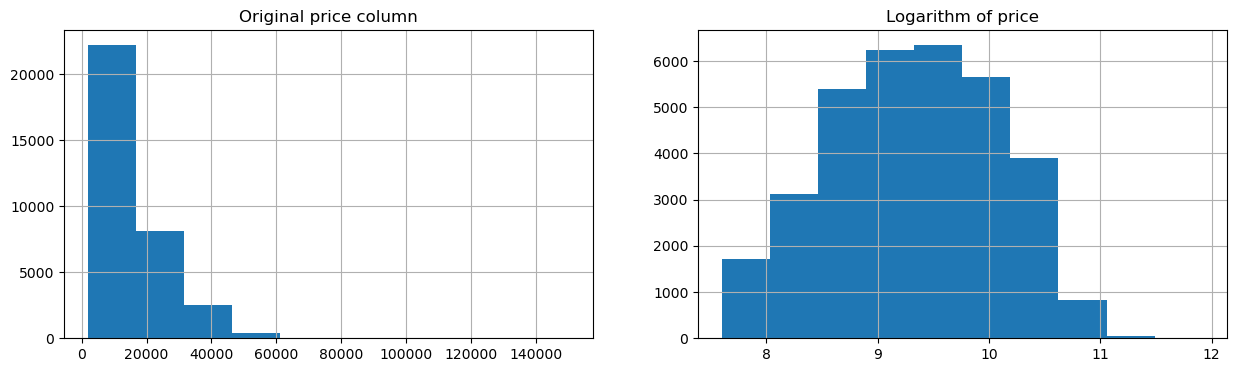

In [86]:
# histogram of 'price'
fig, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].hist(vehicle['price'])
ax[0].grid()
ax[0].set_title('Original price column')
ax[1].hist(np.log1p(vehicle['price']))
ax[1].grid()
ax[1].set_title('Logarithm of price');

In [87]:
# remove more outliers from 'price' and 'odometer' using interquartile range IQR method
outliers_list = ['price','odometer']
for col in outliers_list:
    Q1 = vehicle[col].quantile(0.25)
    Q3 = vehicle[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    vehicle = vehicle[(vehicle[col] >= lower_bound) & (vehicle[col] <= upper_bound)]

In [88]:
# check info
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32164 entries, 34 to 426737
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         32164 non-null  int64  
 1   year          32164 non-null  float64
 2   manufacturer  32164 non-null  object 
 3   model         32164 non-null  object 
 4   condition     32164 non-null  object 
 5   cylinders     32164 non-null  object 
 6   odometer      32164 non-null  float64
 7   transmission  32164 non-null  object 
 8   drive         32164 non-null  object 
 9   type          32164 non-null  object 
 10  paint_color   32164 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 2.9+ MB


**Price vs Year**   
Price has a positive relationship with Year.  Newer used cars cost more.

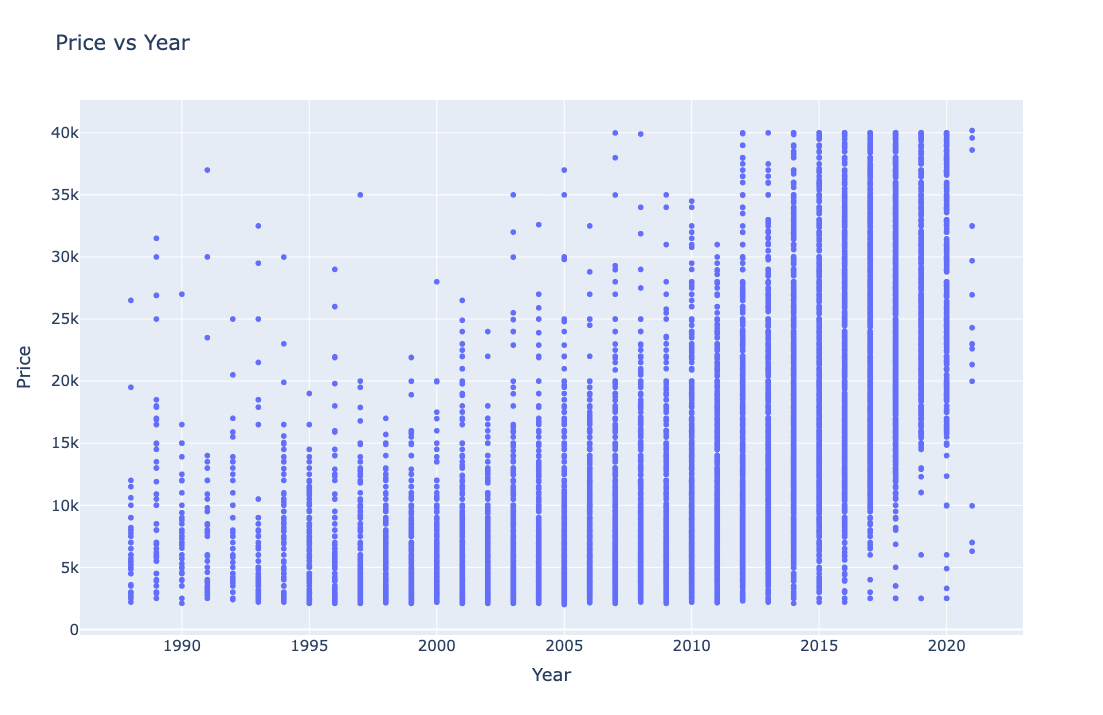

In [89]:
# plot Price vs Year
fig = go.Figure()
fig.add_trace(go.Scattergl(
    x = vehicle['year'],
    y = vehicle['price'],
    mode = 'markers'
))
fig.update_layout(
    height=700,
    width=1200,
    xaxis_title='Year',
    yaxis_title='Price',
    title='Price vs Year',
    font_size=15)
fig.show()

**Price vs Odometer**   
Price has a negative relationship with Odometer.  Used cars with more mileage cost less.

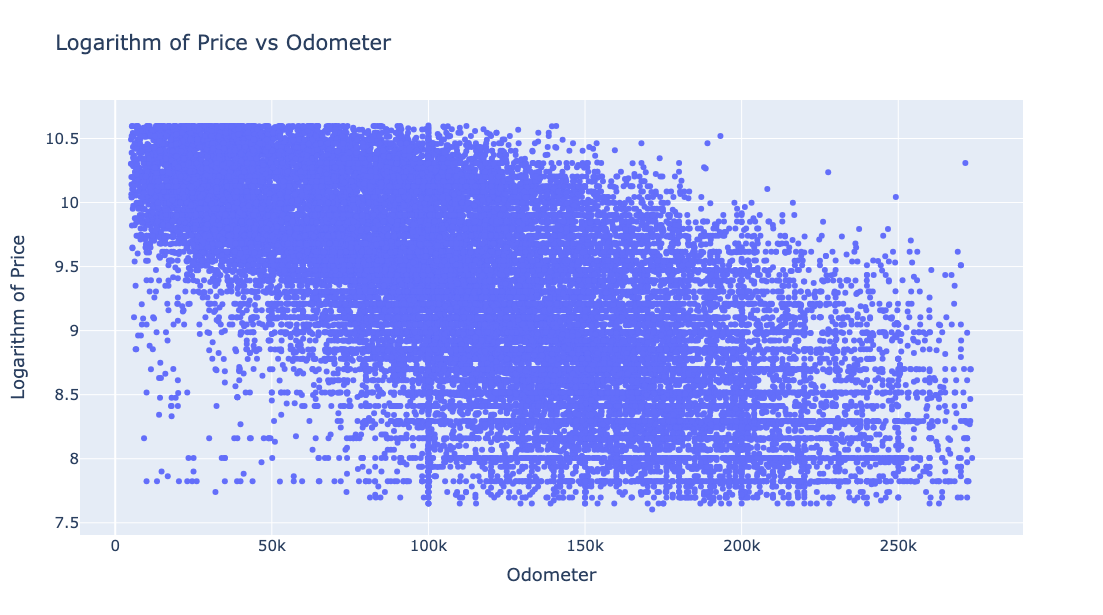

In [90]:
# plot Logarithm of Price vs Odometer
fig = go.Figure()
fig.add_trace(go.Scatter(
    x = vehicle['odometer'],
    y = np.log1p(vehicle['price']),
    mode = 'markers'
))
fig.update_layout(
    height=600,
    width=1200,
    xaxis_title='Odometer',
    yaxis_title='Logarithm of Price',
    title='Logarithm of Price vs Odometer',
    font_size=15)
fig.show()

**Heat Map - Price, Year and Odometer**   
The heat map shows the positive (0.61) relationship of Price and Year, the negative (-0.55) relationship of Price and Odometer
and the negative (-0.58) relationship of Odometer and Year.

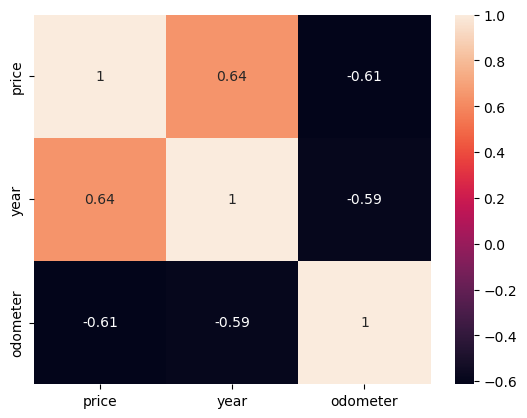

In [91]:
# heat map of numeric features
df = vehicle[['price','year','odometer']]
sns.heatmap(df.corr(), annot=True);

In [92]:
# for ordinal encoding of column 'condition', check the value counts first
value_count_condition = vehicle['condition'].value_counts()
value_count_condition

condition
excellent    24096
good          5940
like new      1600
fair           528
Name: count, dtype: int64

In [93]:
# set the following order for 'condition'
ordinal_condition = {
    'fair': 1,
    'good': 2,
    'like new': 3,
    'excellent': 4
}

In [94]:
# provide encoded column
vehicle['encoded_condition'] = vehicle['condition'].map(ordinal_condition)

In [95]:
#check info
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32164 entries, 34 to 426737
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              32164 non-null  int64  
 1   year               32164 non-null  float64
 2   manufacturer       32164 non-null  object 
 3   model              32164 non-null  object 
 4   condition          32164 non-null  object 
 5   cylinders          32164 non-null  object 
 6   odometer           32164 non-null  float64
 7   transmission       32164 non-null  object 
 8   drive              32164 non-null  object 
 9   type               32164 non-null  object 
 10  paint_color        32164 non-null  object 
 11  encoded_condition  32164 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 3.2+ MB


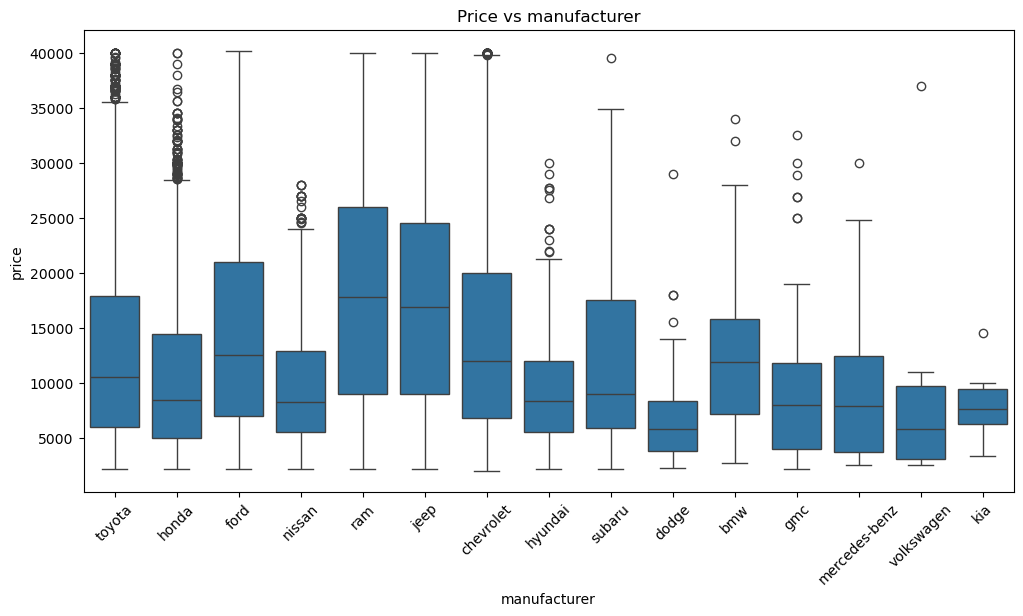

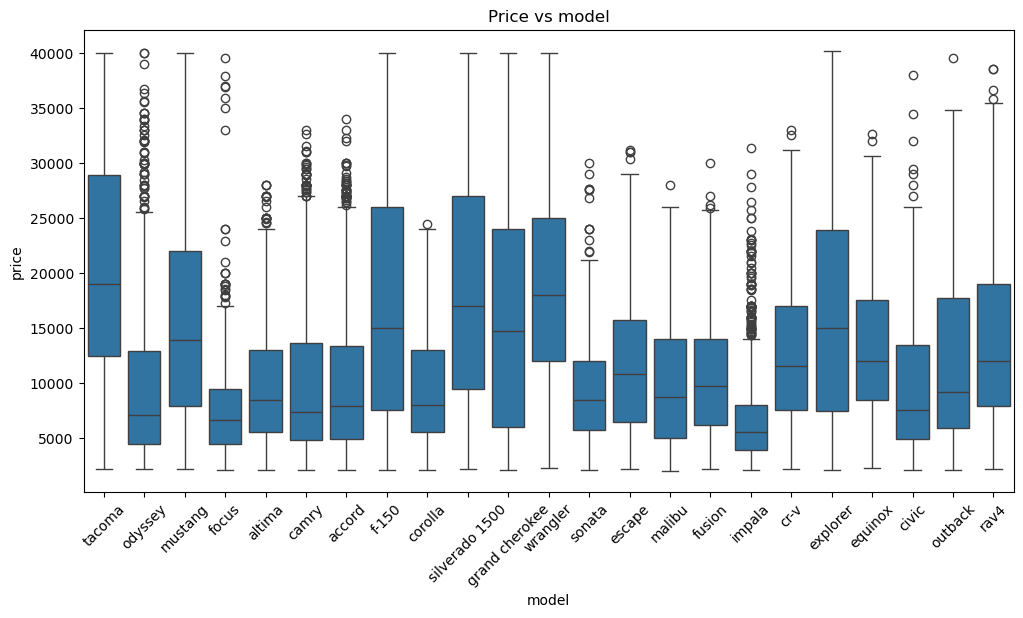

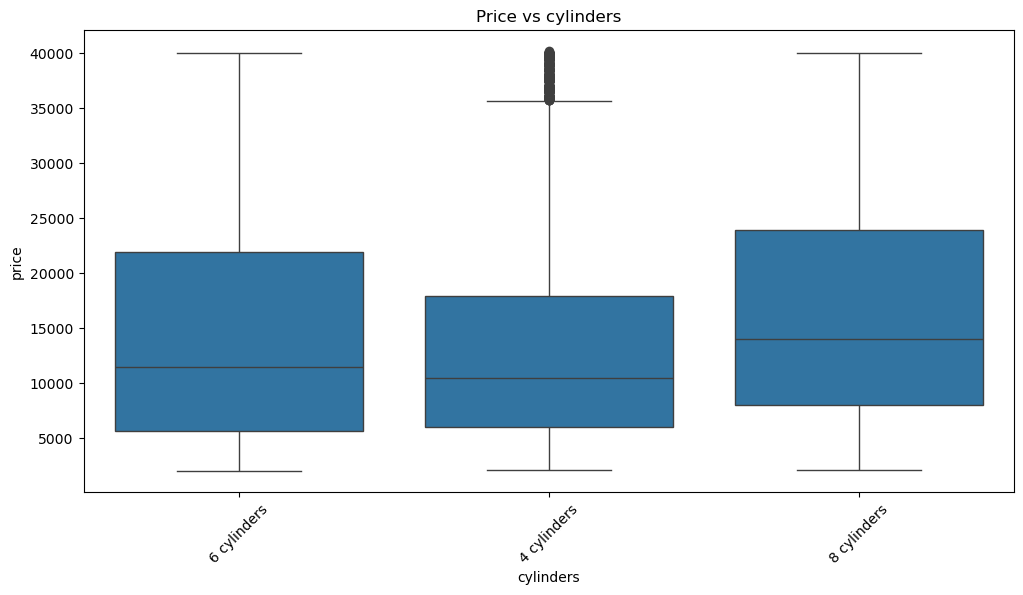

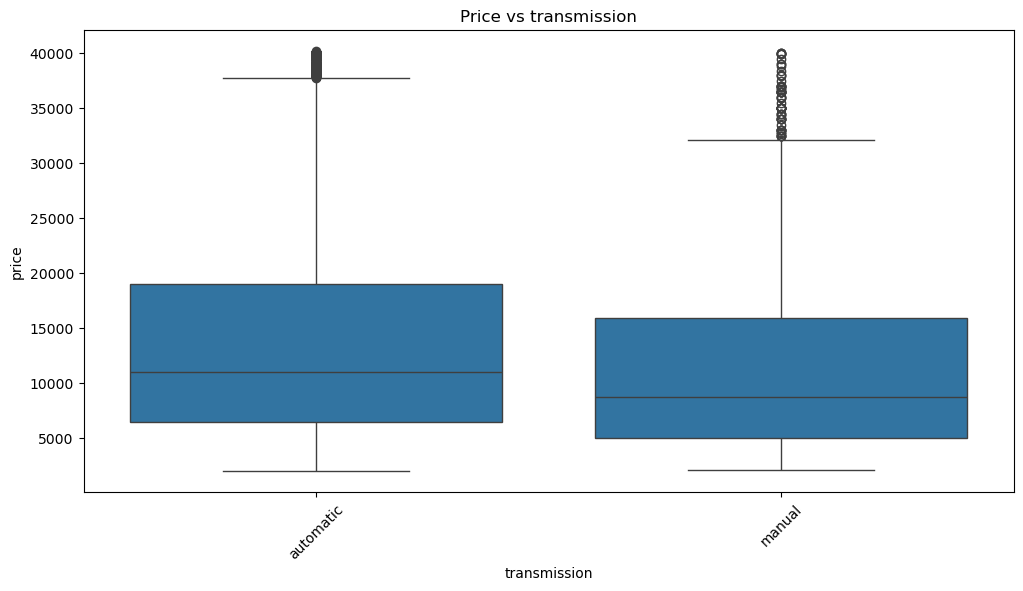

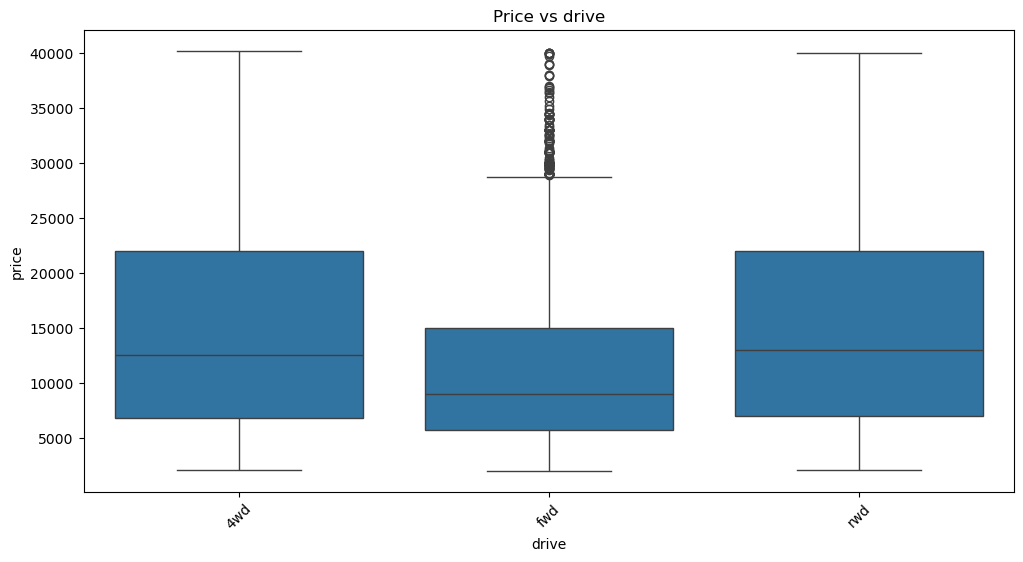

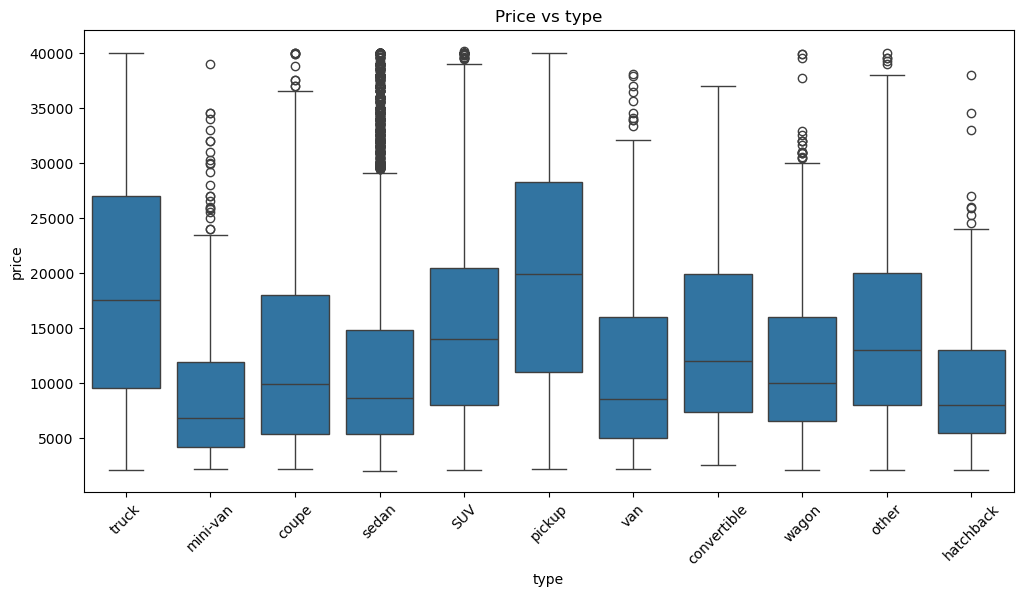

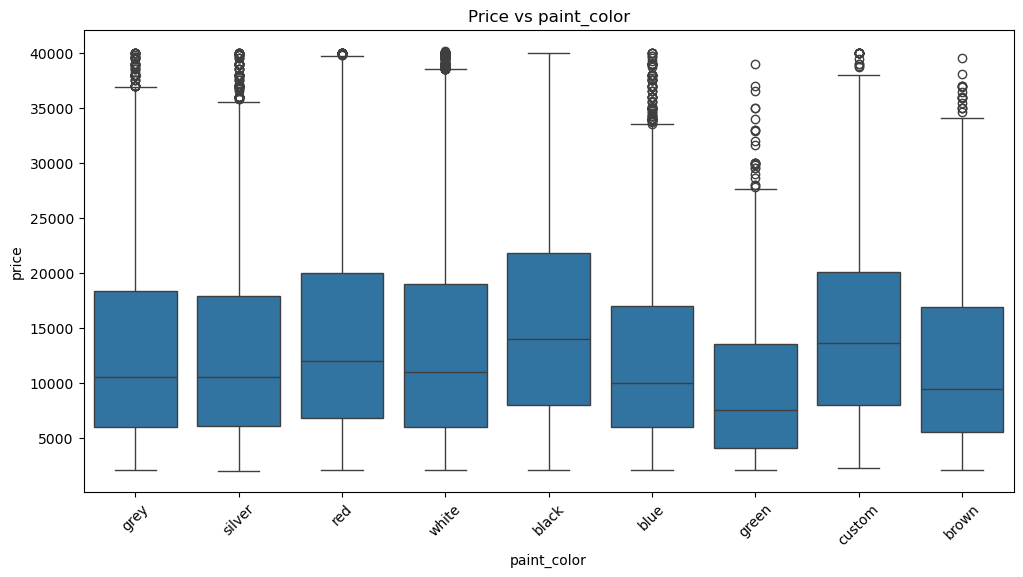

In [96]:
# box plots of price vs categorical features
def plot_price_vs_categorical(df, categorical_col):
    plt.figure(figsize=(12,6))
    sns.boxplot(data=df, x=categorical_col, y='price')
    plt.xticks(rotation=45)
    plt.title(f'Price vs {categorical_col}')
    plt.show()

for col in ['manufacturer','model','cylinders','transmission','drive','type','paint_color']:
    plot_price_vs_categorical(vehicle, col)

In [97]:
# list categorical features
categorical_cols = ['manufacturer','model','cylinders','transmission','drive','type','paint_color',]

In [98]:
# encode categorical features
vehicle_ohe = pd.get_dummies(vehicle[categorical_cols], drop_first=False)

In [99]:
# combine encoded features
vehicle_ohe_oe = pd.concat([
    vehicle.drop(categorical_cols + ['condition'], axis=1),
    vehicle_ohe
], axis=1)
vehicle_ohe_oe.head()

,price,year,odometer,encoded_condition,manufacturer_bmw,manufacturer_chevrolet,manufacturer_dodge,manufacturer_ford,manufacturer_gmc,manufacturer_honda,...,type_wagon,paint_color_black,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_red,paint_color_silver,paint_color_white
34,35000,2019.0,43000.0,4,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
59,14000,2012.0,95000.0,4,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
170,13950,2011.0,151060.0,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
187,4500,2008.0,187016.0,4,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
196,3200,2005.0,189886.0,2,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True


In [100]:
# check info, ensure no missing features
vehicle_ohe_oe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32164 entries, 34 to 426737
Data columns (total 70 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price                       32164 non-null  int64  
 1   year                        32164 non-null  float64
 2   odometer                    32164 non-null  float64
 3   encoded_condition           32164 non-null  int64  
 4   manufacturer_bmw            32164 non-null  bool   
 5   manufacturer_chevrolet      32164 non-null  bool   
 6   manufacturer_dodge          32164 non-null  bool   
 7   manufacturer_ford           32164 non-null  bool   
 8   manufacturer_gmc            32164 non-null  bool   
 9   manufacturer_honda          32164 non-null  bool   
 10  manufacturer_hyundai        32164 non-null  bool   
 11  manufacturer_jeep           32164 non-null  bool   
 12  manufacturer_kia            32164 non-null  bool   
 13  manufacturer_mercedes-benz  32164 

**MODELING**   
After data cleaning, imputation of missing values, removal of outliers and others, 32,164 rows remained.  Feature predictors were selected using SequentialFeatureSelector which identified 9 features to select out of 69 original features.  

**Sequential Feature Selection**

In [101]:
# define X and y
X = vehicle_ohe_oe.drop('price', axis=1)
y = np.log1p(vehicle_ohe_oe['price'])
X.head()

,year,odometer,encoded_condition,manufacturer_bmw,manufacturer_chevrolet,manufacturer_dodge,manufacturer_ford,manufacturer_gmc,manufacturer_honda,manufacturer_hyundai,...,type_wagon,paint_color_black,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_red,paint_color_silver,paint_color_white
34,2019.0,43000.0,4,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
59,2012.0,95000.0,4,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
170,2011.0,151060.0,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
187,2008.0,187016.0,4,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
196,2005.0,189886.0,2,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [102]:
# split dataset to train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [103]:
# calculate the score R^2 for the respective number of features selected 
results = []
for n in range(1, X_train.shape[1]):
    sfs = SequentialFeatureSelector(
        Ridge(alpha=1.0),
        n_features_to_select=n,
        direction='forward',
       cv=5,
       n_jobs=-1
    )
    sfs.fit(X_train, y_train)
    selected_features = X_train.columns[sfs.get_support()]
    model = Ridge(alpha=1.0)
    model.fit(X_train[selected_features], y_train)
    score = model.score(X_test[selected_features], y_test)
    results.append(score)

print(results)

[0.47506982644809215, 0.54464360822187, 0.6293795306919696, 0.6695460624628699, 0.7007080240350579, 0.7336609332566663, 0.7649802763171014, 0.7753010292386664, 0.7834022592005199, 0.7885589164725872, 0.7930305234977049, 0.7971294209685352, 0.8003154855131416, 0.8032734479175416, 0.8071801590125635, 0.8087909404720537, 0.810929924290155, 0.8125777456981916, 0.8140684523757814, 0.8149323400953193, 0.8155708973534075, 0.8158074468619577, 0.8162672174638907, 0.8168651007466656, 0.8174967070554279, 0.8178370055463724, 0.8180878153908793, 0.8181048622574811, 0.8181160085639464, 0.8181339536584646, 0.8186201865158385, 0.8188024055891711, 0.8188765458095707, 0.8188597248564591, 0.8189122209708779, 0.8189208602660768, 0.8191440609770344, 0.8192744364630107, 0.8204318143477436, 0.8203871839925492, 0.8206413381782355, 0.8206029028706016, 0.8210025691380382, 0.8209966627087526, 0.8211643399627849, 0.8218604115474505, 0.8224277922889607, 0.8226025507349888, 0.8227728050395492, 0.8227376391552739, 0

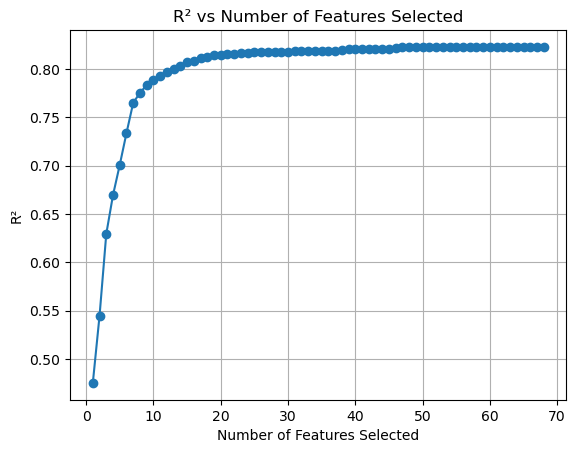

In [104]:
# plot the results
plt.plot(range(1, X_train.shape[1]), results, marker='o')
plt.xlabel('Number of Features Selected')
plt.ylabel('R\u00B2')
plt.title('R\u00B2 vs Number of Features Selected')
plt.grid()
plt.show()

In [105]:
# determine number of features to select
results = np.array(results)
diffs_results = np.diff(results)
threshold = 0.008
optimal_number = np.where(diffs_results < threshold)[0][0]+1
print(f'The optimal number of features to select is {optimal_number}.')

The optimal number of features to select is 9.


In [106]:
# identify the features to select
final_sfs = SequentialFeatureSelector(
     Ridge(alpha=1.0),
     n_features_to_select=optimal_number,
     direction='forward',
     cv=5,
     n_jobs=-1
)
final_sfs.fit(X_train, y_train)
final_selected_features = final_sfs.get_feature_names_out()

print(f'The features to select are:', list(final_selected_features))

The features to select are: ['year', 'odometer', 'encoded_condition', 'model_f-150', 'model_focus', 'model_silverado 1500', 'model_tacoma', 'model_wrangler', 'type_sedan']


In [107]:
# list features to select
features_to_select = ['year', 'odometer', 'encoded_condition', 'model_f-150', 'model_focus', 'model_silverado 1500',\
                      'model_tacoma', 'model_wrangler', 'type_sedan']

In [108]:
# define a new X
X = vehicle_ohe_oe[['year', 'odometer', 'encoded_condition', 'model_f-150', 'model_focus', 'model_silverado 1500',\
                      'model_tacoma', 'model_wrangler', 'type_sedan']]

In [109]:
# split dataset to train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [110]:
# define a simple cross validation function to obtain the optimal degree
def simple_cross_validation(X_train, X_test, y_train, y_test):
    best_pipe = None
    best_mse = np.inf
    for i in range(1, 7):
        pipe = Pipeline([
            ('pfeat', PolynomialFeatures(degree=i, include_bias=False)),
            ('linreg', LinearRegression())])
        pipe.fit(X_train, y_train)
        test_preds = pipe.predict(X_test)
        test_mse = mean_squared_error(y_test, test_preds)
        if test_mse < best_mse:
            best_mse = test_mse
            best_pipe = pipe
    return best_pipe

In [111]:
# compute for the optimal degree
best_model = simple_cross_validation(X_train, X_test, y_train, y_test)
best_model.get_params()

{'memory': None,
 'steps': [('pfeat', PolynomialFeatures(degree=3, include_bias=False)),
  ('linreg', LinearRegression())],
 'transform_input': None,
 'verbose': False,
 'pfeat': PolynomialFeatures(degree=3, include_bias=False),
 'linreg': LinearRegression(),
 'pfeat__degree': 3,
 'pfeat__include_bias': False,
 'pfeat__interaction_only': False,
 'pfeat__order': 'C',
 'linreg__copy_X': True,
 'linreg__fit_intercept': True,
 'linreg__n_jobs': None,
 'linreg__positive': False,
 'linreg__tol': 1e-06}

In [112]:
# obtain the optimal degree
optimal_degree = best_model.named_steps['pfeat'].get_params()['degree']
print(f'The optimal degree is: {optimal_degree}')

The optimal degree is: 3


In [113]:
# find the optimal alpha for Ridge
alphas = [0.001, 0.01, 0.1, 10, 100]
ridge_cv = RidgeCV(alphas=alphas, scoring='r2')
ridge_cv.fit(X_train, y_train)
print(f'The best alpha for Ridge is:', ridge_cv.alpha_)

The best alpha for Ridge is: 0.1


In [114]:
# find the optimal alpha for Lasso
lasso_cv = LassoCV(
    alphas=None, 
    cv=5,
    random_state=42)
lasso_cv.fit(X_train, y_train)
print(f'The best alpha for Lasso is:', lasso_cv.alpha_)

The best alpha for Lasso is: 25.550353684573526


In [115]:
# construct a Linear Regression model and calculate the mean squared errors
linreg_pipe = Pipeline([
    ('polyfeatures', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())])
linreg_pipe.fit(X_train, y_train)
train_preds_linreg = linreg_pipe.predict(X_train)
test_preds_linreg = linreg_pipe.predict(X_test)
train_mse_linreg = mean_squared_error(y_train, train_preds_linreg)
test_mse_linreg = mean_squared_error(y_test, test_preds_linreg)
print(f'For Linear Regression, the train Mean Squared Error is: {train_mse_linreg: .5f}')
print(f'For Linear Regression, the test Mean Squared Error is: {test_mse_linreg: .5f}')

For Linear Regression, the train Mean Squared Error is:  0.09314
For Linear Regression, the test Mean Squared Error is:  0.09467


In [116]:
# construct a Ridge model and calculate the mean squared errors
ridge_pipe = Pipeline([
    ('polyfeatures', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=0.1))])
ridge_pipe.fit(X_train, y_train)
train_preds_ridge = ridge_pipe.predict(X_train)
test_preds_ridge = ridge_pipe.predict(X_test)
train_mse_ridge = mean_squared_error(y_train, train_preds_ridge)
test_mse_ridge = mean_squared_error(y_test, test_preds_ridge)
print(f'For Ridge, the train Mean Squared Error is: {train_mse_ridge: .5f}')
print(f'For Ridge, the test Mean Squared Error is: {test_mse_ridge: .5f}')

For Ridge, the train Mean Squared Error is:  0.09747
For Ridge, the test Mean Squared Error is:  0.09918


In [117]:
# construct a Lasso model and calculate the mean squared errors
lasso_pipe = Pipeline([
    ('polyfeatures', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=25.55035))])
lasso_pipe.fit(X_train, y_train)
train_preds_lasso = lasso_pipe.predict(X_train)
test_preds_lasso = lasso_pipe.predict(X_test)
train_mse_lasso = mean_squared_error(y_train, train_preds_lasso)
test_mse_lasso = mean_squared_error(y_test, test_preds_lasso)
print(f'For Lasso, the train Mean Squared Error is: {train_mse_lasso: .5f}')
print(f'For Lasso, the test Mean Squared Error is: {test_mse_lasso: .5f}')

For Lasso, the train Mean Squared Error is:  0.51605
For Lasso, the test Mean Squared Error is:  0.51295


**EVALUATION**   
The Linear Regression Model provided the lowest mean squared error both on the train and test sets. The coefficients of this model were extracted and a full model equation was built using these coefficients.

In [118]:
# dataframe to compare the 3 models
models_df = pd.DataFrame({
    'Train MSE': [round(train_mse_linreg, 4), round(train_mse_ridge, 4), round(train_mse_lasso, 4)],
    'Test MSE': [round(test_mse_linreg, 4), round(test_mse_ridge, 4), round(test_mse_lasso, 4)],
    'Model':  ['Linear Regression','Ridge','Lasso']
    })
models_df = models_df.set_index('Model')
models_df

,Train MSE,Test MSE
Model,,
Linear Regression,0.0931,0.0947
Ridge,0.0975,0.0992
Lasso,0.5161,0.5129


**Choose Linear Regression Model**    
Because this model has the lowest train and test mean squared error, Linear Regression was chosen to be the prediction model.

In [119]:
# display the Linear Regression coefficients in a dataframe
feature_names = linreg_pipe.named_steps['polyfeatures'].get_feature_names_out()
coefs_linreg = linreg_pipe.named_steps['linreg'].coef_
coefs_linreg_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs_linreg
})
print(coefs_linreg_df.head(),'\n','\n',  coefs_linreg_df.tail())

             Feature  Coefficient
0               year -8686.407714
1           odometer  -336.764074
2  encoded_condition   158.797034
3        model_f-150  -199.369382
4        model_focus   214.818544 
 
                          Feature  Coefficient
214    model_tacoma type_sedan^2    -0.289159
215             model_wrangler^3  -686.421382
216  model_wrangler^2 type_sedan    -0.086950
217  model_wrangler type_sedan^2    -0.086950
218                 type_sedan^3   -11.374699


In [120]:
# list feature names
feature_names_list = list(linreg_pipe.named_steps['polyfeatures'].get_feature_names_out())
feature_names_list

['year',
 'odometer',
 'encoded_condition',
 'model_f-150',
 'model_focus',
 'model_silverado 1500',
 'model_tacoma',
 'model_wrangler',
 'type_sedan',
 'year^2',
 'year odometer',
 'year encoded_condition',
 'year model_f-150',
 'year model_focus',
 'year model_silverado 1500',
 'year model_tacoma',
 'year model_wrangler',
 'year type_sedan',
 'odometer^2',
 'odometer encoded_condition',
 'odometer model_f-150',
 'odometer model_focus',
 'odometer model_silverado 1500',
 'odometer model_tacoma',
 'odometer model_wrangler',
 'odometer type_sedan',
 'encoded_condition^2',
 'encoded_condition model_f-150',
 'encoded_condition model_focus',
 'encoded_condition model_silverado 1500',
 'encoded_condition model_tacoma',
 'encoded_condition model_wrangler',
 'encoded_condition type_sedan',
 'model_f-150^2',
 'model_f-150 model_focus',
 'model_f-150 model_silverado 1500',
 'model_f-150 model_tacoma',
 'model_f-150 model_wrangler',
 'model_f-150 type_sedan',
 'model_focus^2',
 'model_focus mode

**DEPLOYMENT**  
The full model equation would be placed inside a production application like, for example, a web app, API (Application Programming Interface), mobile app and Excel. The model was trained on a log transformed 'price', therefore, a transformation is required to get predictions back on the original scale.

In [121]:
# build the full model equation
intercept = 0
equation_terms = []
for feature, coef in zip(feature_names, coefs_linreg):
    term = f'({coef:.6f})*{feature}'
    equation_terms.append(term)
full_model_equation = "price = " + f"{intercept} +  " + " + ".join(equation_terms)
print(full_model_equation)

price = 0 +  (-8686.407714)*year + (-336.764074)*odometer + (158.797034)*encoded_condition + (-199.369382)*model_f-150 + (214.818544)*model_focus + (-323.671242)*model_silverado 1500 + (-454.764209)*model_tacoma + (-686.421383)*model_wrangler + (-11.374699)*type_sedan + (17329.900872)*year^2 + (649.110787)*year odometer + (-289.327229)*year encoded_condition + (593.165559)*year model_f-150 + (-643.009530)*year model_focus + (965.736238)*year model_silverado 1500 + (1363.937426)*year model_tacoma + (2058.534025)*year model_wrangler + (38.523851)*year type_sedan + (31.122260)*odometer^2 + (-17.089675)*odometer encoded_condition + (3.993709)*odometer model_f-150 + (1.555026)*odometer model_focus + (1.150819)*odometer model_silverado 1500 + (2.172672)*odometer model_tacoma + (2.065932)*odometer model_wrangler + (4.636891)*odometer type_sedan + (-11.108365)*encoded_condition^2 + (-4.288891)*encoded_condition model_f-150 + (-2.028875)*encoded_condition model_focus + (2.820455)*encoded_condit